In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Solving the piece-wise cubic trajectory for time at a given position.
## Problem set-up
The general cubic equation
$$
at^3 + bt^2 + ct + d = 0
$$
can be modified to the depressed form
$$
x^3 + px + q = 0
$$
with a change of variable
$$
t = x - \frac{b}{3a},
$$
where
$$
p = \frac{3ac - b^2}{3a^2}, \quad q = \frac{2b^3 - 9abc + 27da^2}{27a^3}.
$$
The discriminant of the equation is
$$
\Delta = -(4p^3 + 27q^2).
$$


## Piece 1: t < t1
During this period, the shutter accelerates with a constant positive jerk $j_0$. The model parameters are fit on normalized data so that $j_0$ is always positive for trajectories moving in either directions. For the same reason, $j_1$ is always negative and $j_2$ is always positive. The trajectory for this piece is
$$
s = \frac{1}{6}j_0t^3
$$
whose solution is arbitrary. But for completeness, we follow the general formula and rewrite it as
$$
\frac{1}{6}j_0t^3 - s = 0,
$$
with 
$$
a = \frac{1}{6}j_0, \quad b = c = 0, \quad d = -s
$$
and 
$$
p = 0, \quad q = -\frac{6s}{j_0}, \quad \Delta = -\frac{972s^2}{j_0^2}.
$$
The model trajectory always starts at position 0, and beyond the initial location we have
$$
0 \lt s \lt SP_1 = \frac{1}{6}j_0t_1^3,
$$
where $SP_1 = \frac{1}{6}j_0t_1^3$ is the first pivot point location at the pivot time $t_1$. For this period, we always have
$$
\Delta < 0, \quad q < 0
$$
which implies there is one real root (Cardano's formula). 

### Verification for Piece 1:

In [2]:
data = pd.read_pickle('data_example.pkl')

## timeMotor and timeHall are (timestamps - startTime)
## posMotor and posHall are RAW position (not subtracting startPosition)

data.columns


Index(['startTime', 'timeMotor', 'timeHall', 'posMotor', 'posHall', 'id',
       'isOn', 'paramsMotor', 'paramsHall', 'fileName', 'fileType', 'obsId',
       'version', 'startPosition', 'targetPosition', 'endPosition',
       'targetDuration', 'actionDuration', 'side', 'isOpen'],
      dtype='object')

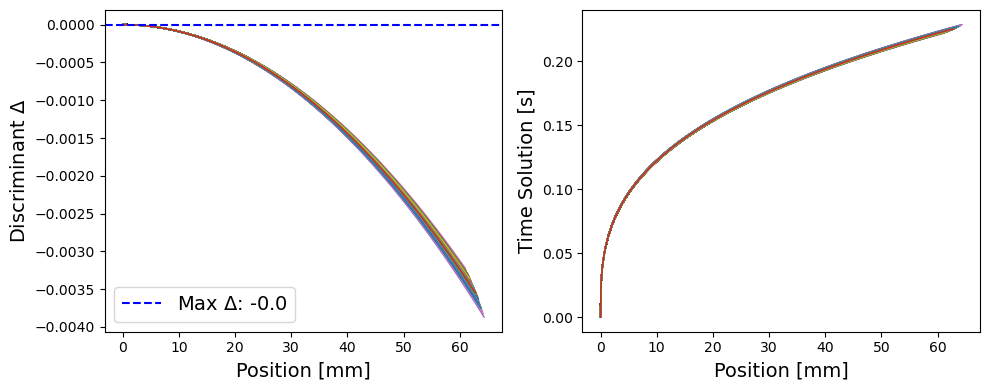

In [3]:

max_delta = -1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for params in data['paramsMotor']:

    t0, t1, t2, j0, j1, j2 = params
    
    SP1 = j0 * (t1**3) / 6
    s = np.linspace(0, SP1, 1000)
    
    a = j0/6
    b = 0
    c = 0
    d = -s
    
    p = (3*a*c - b**2) / (3*a**2)
    q = (2*b**3 - 9*a*b*c + 27*d*a**2) / (27*a**3)
    delta = - (4*p**3 + 27*q**2)
    max_delta = max(max_delta, np.max(delta))

    u1 = -q/2 + np.sqrt( (q**2)/4 + (p**3)/27)
    u2 = -q/2 - np.sqrt( (q**2)/4 + (p**3)/27)
    root = np.cbrt(u1) + np.cbrt(u2)  - b/(3*a)
    
    ax1.plot(s, delta, lw=1)
    ax2.plot(s, root, lw=1)


ax1.axhline(y=max_delta, c='b', ls='--', label=rf'Max $\Delta$: {max_delta}')
ax1.set_ylabel(r'Discriminant $\Delta$', fontsize=14)
ax1.set_xlabel('Position [mm]', fontsize=14)

ax2.set_ylabel(r'Time Solution [s]', fontsize=14)
ax2.set_xlabel('Position [mm]', fontsize=14)

ax1.legend(fontsize=14)

plt.tight_layout()
plt.show()


## Piece 2: t1 < t < t2
During this period, the shutter continues to accelerate with a decreasing acceleration untill the acceleration turns negative, then the shutter decelerates untill the second pivot point position $SP_2$. **The trajectory mid-point is found within this period.** The trajectory for this piece is
$$
s = \frac{1}{6}j_1 t^3 + \frac{1}{2}A_1 t^2 + V_1 t + S_1,
$$
with
$$
A_1 = j_0 t_1, \quad V_1 = \frac{1}{2} (j_0 - j_1) t_1^2 - A_1 t_1,
$$
$$
S_1 = \frac{1}{6} (j_0 - j_1) t_1^3 - \frac{1}{2} A_1 t_1^2 - V_1 t_1.
$$
The cubic equation then has coefficients:
$$
a = \frac{1}{6}j_1, \quad b =  \frac{1}{2}A_1, \quad c = V_1, \quad d = S_1 - s.
$$

In the following, we'll see numerically that $\Delta$ is always greater than 0 for this period, which indicates there are three roots. We'll also see that **only one root is physically correct.**

### Verification for Piece 2:

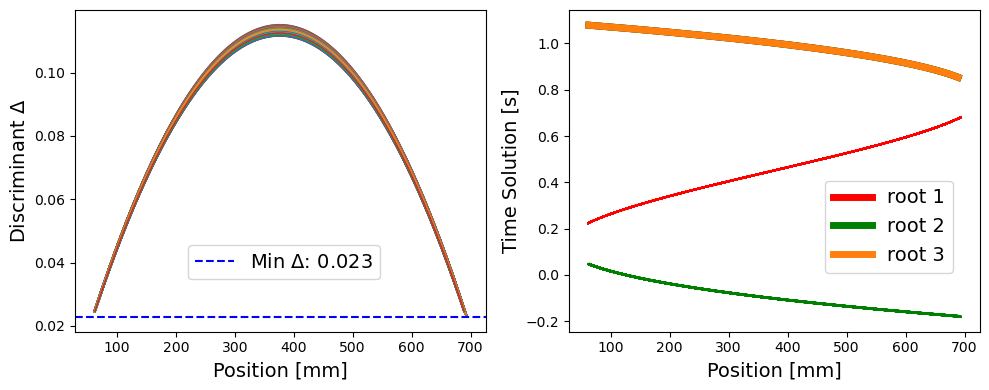

In [4]:

min_delta = 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for params in data['paramsMotor']:

    t0, t1, t2, j0, j1, j2 = params

    A1 = (j0 - j1) * t1
    V1 = (j0 - j1) * t1**2 / 2 - A1*t1
    S1 = (j0 - j1) * t1**3 / 6 - A1*t1**2 / 2 - V1*t1
    
    SP1 = j0 * (t1**3) / 6
    SP2 = j1 * t2**3 / 6 + A1*t2**2/2 + V1*t2 + S1
    s = np.linspace(SP1, SP2, 1000)
    
    a = j1/6
    b = A1/2
    c = V1
    d = S1 - s
    
    p = (3*a*c - b**2) / (3*a**2)
    q = (2*b**3 - 9*a*b*c + 27*d*a**2) / (27*a**3)
    delta = - (4*p**3 + 27*q**2)
    min_delta = min(min_delta, np.min(delta))

    
    for k, c in zip([1, 2, 3], ['r', 'g', 'C1']):
        root = 2*np.sqrt(-p/3) * np.cos( np.arccos(3*q*np.sqrt(-3/p)/(2*p)) / 3 - 2*k*np.pi/3)  - b/(3*a)
        plt.plot(s, root, lw=1, color=c)

    ax1.plot(s, delta, lw=1)


for k, c in zip([1, 2, 3], ['r', 'g', 'C1']):
    ax2.plot(s, root, lw=5, color=c, label=f'root {k}')


ax1.axhline(y=min_delta, c='b', ls='--', label=rf'Min $\Delta$: {np.around(min_delta, decimals=3)}')
ax1.set_ylabel(r'Discriminant $\Delta$', fontsize=14)
ax1.set_xlabel('Position [mm]', fontsize=14)

ax2.set_ylabel(r'Time Solution [s]', fontsize=14)
ax2.set_xlabel('Position [mm]', fontsize=14)

ax1.legend(fontsize=14, bbox_to_anchor=(0.25, 0.3))
ax2.legend(fontsize=14, bbox_to_anchor=(0.6, 0.5))

plt.tight_layout()
plt.show()


## Piece 3: t > t2
During this period, the shutter continues to decrease till the end of motion. The trajectory for this piece is
$$
s = \frac{1}{6}j_2 t^3 + \frac{1}{2}A_2 t^2 + V_2 t + S_2
$$
with
$$
\begin{align}
A_2 & = (j_0 - j_1) t_1 + (j_1 - j_2) t_2, \\
V_2 & = \frac{1}{2} (j_1 - j_2) t_2^2 + (A_1 - A_2) t_2 + V1, \\
S_2 & = \frac{1}{6} (j_1 - j_2) t_2^3 + \frac{1}{2} (A_1 - A_2) t_2^2 + (V_1 - V_2) t_2 + S_1,
\end{align}
$$
and
$$
a = \frac{1}{6}j_2, \quad b =  \frac{1}{2}A_2, \quad c = V_2, \quad d = S_2 - s.
$$

In the following, we'll see numerically that $\Delta < 0$ again.

### Verification for Piece 3:

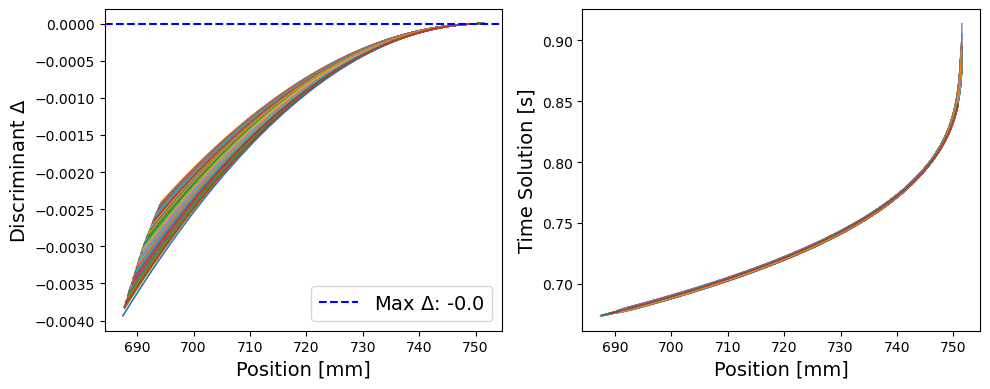

In [5]:

max_delta = -1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for params, startPos, endPos in zip(data['paramsMotor'], data['startPosition'], data['endPosition']):

    t0, t1, t2, j0, j1, j2 = params

    A1 = (j0 - j1) * t1
    A2 = A1 + (j1 - j2) * t2
    
    V1 = (j0 - j1) * t1**2 / 2 - A1*t1
    V2 = V1 + (j1 - j2) * t2**2 / 2 + (A1 - A2)*t2
    
    S1 = (j0 - j1) * t1**3 / 6 - A1*t1**2 / 2 - V1*t1
    S2 = S1 + (j1 - j2) * t2**3 / 6 + (A1 - A2)*t2**2/2 + (V1 - V2)*t2
    
    SP1 = j0 * (t1**3) / 6
    SP2 = j1 * t2**3 / 6 + A1*t2**2/2 + V1*t2 + S1

    ending = max(startPos, endPos)
    s = np.linspace(SP2, ending, 500)
    
    a = j2/6
    b =  A2/2
    c = V2
    d = S2 - s
    
    p = (3*a*c - b**2) / (3*a**2)
    q = (2*b**3 - 9*a*b*c + 27*d*a**2) / (27*a**3)
    delta = - (4*p**3 + 27*q**2)
    
    max_delta = max(max_delta, np.max(delta))
    
    u1 = -q/2 + np.sqrt( (q**2)/4 + (p**3)/27)
    u2 = -q/2 - np.sqrt( (q**2)/4 + (p**3)/27)
    root = np.cbrt(u1) + np.cbrt(u2)  - b/(3*a)

    ax1.plot(s, delta, lw=1)
    ax2.plot(s, root, lw=1)


ax1.axhline(y=max_delta, c='b', ls='--', label=rf'Max $\Delta$: {np.around(max_delta, decimals=4)}')

ax1.set_ylabel(r'Discriminant $\Delta$', fontsize=14)
ax2.set_ylabel(r'Time Solution [s]', fontsize=14)

ax1.set_xlabel('Position [mm]', fontsize=14)
ax2.set_xlabel('Position [mm]', fontsize=14)

ax1.legend(fontsize=14)

plt.tight_layout()
plt.show()


## A note on $\Delta=0$
We *might* have $\Delta = 0$ at the beginning and/or at the end (I have not seen it happen, but saw small $\Delta$ at these positions). $\Delta=0$ means multiple non-zero roots:
$$
\mathrm{root} = 0, \quad -\frac{3q}{2p} - \frac{b}{3a} \quad \mathrm{or} \quad \frac{3q}{p} - \frac{b}{3a}.
$$
We surely have root=0 at the beginning. At the end, we could check which root is closer to the approaching solution from piece 3. We'll see that the solution 
$$
\mathrm{root} = -\frac{3q}{2p} - \frac{b}{3a}
$$
is positively correlated with the approaching solution, which implies it is the correct one.

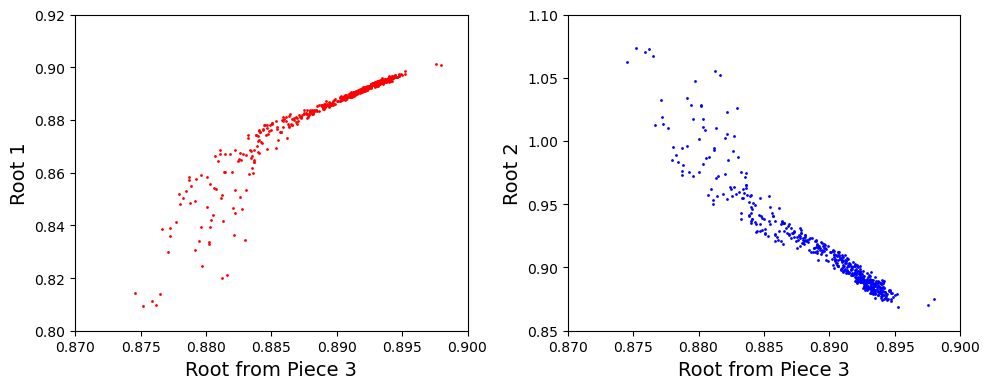

In [6]:

root_branch1 = []
root_branch2 = []
root_approaching = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for params, startPos, endPos in zip(data['paramsMotor'], data['startPosition'], data['endPosition']):

    t0, t1, t2, j0, j1, j2 = params

    s = max(startPos, endPos)
    
    A1 = (j0 - j1) * t1
    A2 = A1 + (j1 - j2) * t2
    
    V1 = (j0 - j1) * t1**2 / 2 - A1*t1
    V2 = V1 + (j1 - j2) * t2**2 / 2 + (A1 - A2)*t2
    
    S1 = (j0 - j1) * t1**3 / 6 - A1*t1**2 / 2 - V1*t1
    S2 = S1 + (j1 - j2) * t2**3 / 6 + (A1 - A2)*t2**2/2 + (V1 - V2)*t2

    SP1 = j0 * (t1**3) / 6
    SP2 = j1 * t2**3 / 6 + A1*t2**2/2 + V1*t2 + S1

    a = j2/6
    b =  A2/2
    c = V2
    d = S2 - s
    
    p = (3*a*c - b**2) / (3*a**2)
    q = (2*b**3 - 9*a*b*c + 27*d*a**2) / (27*a**3)
        
    root_branch1.append(-3*q/(2*p) - b/(3*a))
    root_branch2.append(3*q/p - b/(3*a))

    u1 = -q/2 + np.sqrt( (q**2)/4 + (p**3)/27)
    u2 = -q/2 - np.sqrt( (q**2)/4 + (p**3)/27)
    root_approaching.append( np.cbrt(u1) + np.cbrt(u2)  - b/(3*a) )
    
ax1.scatter(root_approaching, root_branch1, s=1, c='r')
ax2.scatter(root_approaching, root_branch2, s=1, c='b')

ax1.set_xlabel('Root from Piece 3', fontsize=14)
ax2.set_xlabel('Root from Piece 3', fontsize=14)

ax1.set_ylabel(r'Root 1', fontsize=14)
ax2.set_ylabel(r'Root 2', fontsize=14)

ax1.set_xlim(0.87, 0.9)
ax2.set_xlim(0.87, 0.9)

ax1.set_ylim(0.8, 0.92)
ax2.set_ylim(0.85, 1.1)

plt.tight_layout()
plt.show()


## Putting everything together

In [7]:

def solve_cubic(a, b, c, d):

    ## solving the equation via the depressed form, following
    ## https://en.wikipedia.org/wiki/Cubic_equation#Depressed_cubic
    
    p = (3*a*c - b**2) / (3*a**2)
    q = (2*b**3 - 9*a*b*c + 27*d*a**2) / (27*a**3)
    delta = - (4*p**3 + 27*q**2)

    if delta == 0:
        if p == 0:                        # only happens at s=0
            root = 0
        else:                             # might happen at s~750mm
            root = -3*q/(2*p) - b/(3*a)  
                 
    elif delta < 0:                       # Cardano's formula
        u1 = -q/2 + np.sqrt( (q**2)/4 + (p**3)/27)
        u2 = -q/2 - np.sqrt( (q**2)/4 + (p**3)/27)
    
        root = np.cbrt(u1) + np.cbrt(u2)  - b/(3*a)

    elif delta > 0:
        k = 1     # k = 0, 1, 2 for three real roots; we want k = 1
        root = 2*np.sqrt(-p/3) * np.cos( np.arccos(3*q*np.sqrt(-3/p)/(2*p)) / 3 - 2*k*np.pi/3) - b/(3*a)
        
    return root


def point_model(params, t):
    
    t0, t1, t2, j0, j1, j2 = params
    
    t -= t0
    
    if t < t1:

        s = j0 * (t**3) / 6

    elif (t > t1) and (t < t2):

        A1 = (j0 - j1) * t1
        V1 = (j0 - j1) * t1**2 / 2 - A1*t1
        S1 = (j0 - j1) * t1**3 / 6 - A1*t1**2 / 2 - V1*t1
        
        s = j1 * t**3 / 6 + A1*t**2/2 + V1*t + S1

    elif t > t2:
        
        A1 = (j0 - j1) * t1
        V1 = (j0 - j1) * t1**2 / 2 - A1*t1
        S1 = (j0 - j1) * t1**3 / 6 - A1*t1**2 / 2 - V1*t1
        
        A2 = A1 + (j1 - j2) * t2
        V2 = V1 + (j1 - j2) * t2**2 / 2 + (A1 - A2)*t2
        S2 = S1 + (j1 - j2) * t2**3 / 6 + (A1 - A2)*t2**2/2 + (V1 - V2)*t2
        s = j2 * t**3 / 6 + A2*t**2/2 + V2*t + S2

    else:
        s = np.NaN

    return s
    

def point_model_inv(params, s):
    
    t0, t1, t2, j0, j1, j2 = params
    
    A1 = (j0 - j1) * t1
    A2 = A1 + (j1 - j2) * t2
    
    V1 = (j0 - j1) * t1**2 / 2 - A1*t1
    V2 = V1 + (j1 - j2) * t2**2 / 2 + (A1 - A2)*t2
    
    S1 = (j0 - j1) * t1**3 / 6 - A1*t1**2 / 2 - V1*t1
    S2 = S1 + (j1 - j2) * t2**3 / 6 + (A1 - A2)*t2**2/2 + (V1 - V2)*t2

    SP1 = j0 * (t1**3) / 6
    SP2 = j1 * t2**3 / 6 + A1*t2**2/2 + V1*t2 + S1
    
    if s < SP1:

        # solving for:        s = j0 * (t**3) / 6
        # should be equal to: t = np.cbrt(6*s/j0, 1/3)
        a = j0/6
        b = 0
        c = 0
        d = -s
        t = solve_cubic(a, b, c, d)

    elif (s > SP1) and (s < SP2):

        # solving for:  s = j1 * t**3 / 6 + A1*t**2/2 + V1*t + S1
        a = j1/6
        b =  A1/2
        c = V1
        d = S1 - s
        t = solve_cubic(a, b, c, d)

    elif s > SP2:
        
        # solving for:  s = j2 * t**3 / 6 + A2*t**2/2 + V2*t + S2
        a = j2/6
        b =  A2/2
        c = V2
        d = S2 - s
        t = solve_cubic(a, b, c, d)

    else:
        t = np.NaN

    return t


def model_for_plot(params, time, dflag="+", sP=750):
    
    ## model for plotting. Takes any data (physical or scaled) with both direction.

    s = np.zeros(len(time))

    for i, t in enumerate(time):
        s[i] = point_model(params, t)

    if dflag=='+':
        
        s = s + sP
    
    elif dflag=='-':

        s = sP - s

    return s


def model_inv(s, params, dflag="+", sP=750):
    
    ## model to solve for time giving position

    t0, t1, t2, j0, j1, j2 = params

    if dflag == '+':
        s = s - sP
    if dflag == '-':
        s = sP - s
        
    t = np.zeros(len(s))

    for i, si in enumerate(s):
        t[i] = point_model_inv(params, si)

    return t + t0
        
def is_open(flag=True):
    if flag:
        return 'Open'
    else:
        return 'Close'


# Making Plots

In [8]:
data = pd.read_pickle('data_example.pkl')

## timeMotor and timeHall are (timestamps - startTime)
## posMotor and posHall are RAW position (not subtracting startPosition)

data.columns


Index(['startTime', 'timeMotor', 'timeHall', 'posMotor', 'posHall', 'id',
       'isOn', 'paramsMotor', 'paramsHall', 'fileName', 'fileType', 'obsId',
       'version', 'startPosition', 'targetPosition', 'endPosition',
       'targetDuration', 'actionDuration', 'side', 'isOpen'],
      dtype='object')

In [9]:
## pick a random trajectory id

i = 99

startPosition = data['startPosition'][i]
endPosition = data['endPosition'][i]
params = data['paramsMotor'][i]
time_data = data['timeMotor'][i]
pos_data = data['posMotor'][i]

t0, t1, t2, j0, j1, j2 = params

if startPosition < endPosition:
    direction_flag = '+'
else:
    direction_flag = '-'
    

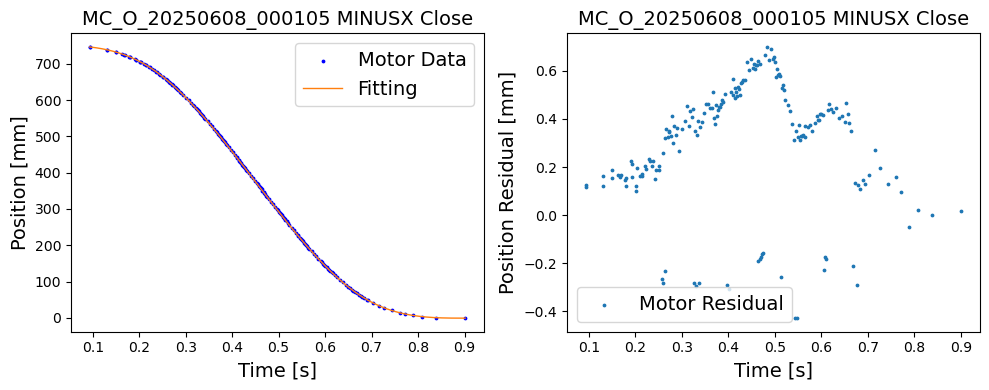

In [10]:
## Plot the shutter data and fitted trajectory

time_grid = np.linspace(time_data.min(), time_data.max(), 500)
pos_fit = model_for_plot(params, time_grid, dflag=direction_flag, sP=startPosition)
pos_res = pos_data - model_for_plot(params, time_data, dflag=direction_flag, sP=startPosition)
# print(pos_fit - data['posFitMotor'][i])   ## should be all 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.scatter(time_data - t0, pos_data, s=3, c='b', label='Motor Data')
ax1.plot(time_grid, pos_fit, lw=1, c='C1', label='Fitting')

ax2.scatter(time_data - t0, pos_res, s=3, label='Motor Residual')

ax1.set_xlabel('Time [s]', fontsize=14)
ax2.set_xlabel('Time [s]', fontsize=14)

ax1.set_ylabel('Position [mm]', fontsize=14)
ax2.set_ylabel('Position Residual [mm]', fontsize=14)

ax1.legend(fontsize=14)
ax2.legend(fontsize=14)

ax1.set_title(data['obsId'][i] + ' ' + data['side'][i] + ' ' + is_open(data['isOpen'][i]), fontsize=14)
ax2.set_title(data['obsId'][i] + ' ' + data['side'][i] + ' ' + is_open(data['isOpen'][i]), fontsize=14)

plt.tight_layout()
plt.show()

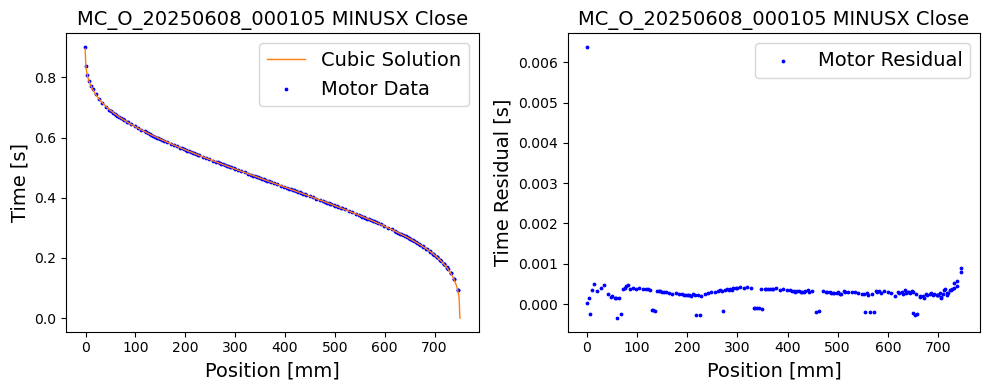

In [11]:
## solve the cubic for time

pos_grid = np.linspace(startPosition, endPosition, 500)
time_solve = model_inv(pos_grid, params, dflag=direction_flag, sP=startPosition)
time_res = time_data - model_inv(pos_data, params, dflag=direction_flag, sP=startPosition)


## plot the solution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(pos_grid, time_solve, lw=1, c='C1', label='Cubic Solution')
ax1.scatter(pos_data, time_data, s=3, c='b', label='Motor Data')

## plot timing residual; might have regular points at the end of motion due to slow motion

ax2.scatter(pos_data, time_res, s=3, c='b', label='Motor Residual')


ax1.set_ylabel('Time [s]', fontsize=14)
ax1.set_xlabel('Position [mm]', fontsize=14)

ax2.set_ylabel('Time Residual [s]', fontsize=14)
ax2.set_xlabel('Position [mm]', fontsize=14)

ax1.legend(fontsize=14)
ax2.legend(fontsize=14)

ax1.set_title(data['obsId'][i] + ' ' + data['side'][i] + ' ' + is_open(data['isOpen'][i]), fontsize=14)
ax2.set_title(data['obsId'][i] + ' ' + data['side'][i] + ' ' + is_open(data['isOpen'][i]), fontsize=14)

plt.tight_layout()
plt.show()